# Dynamics of quantum walk on glued tree

In [1]:
from glue_tree import *

Generating glued tree with depth 3
Each tree has 15 vertices
Total number of vertices: 30

Glued connections between leaves:
  Leaf 7 (Tree 0) ↔ Leaf 27 (Tree 1)
  Leaf 27 (Tree 0) ↔ Leaf 8 (Tree 1)
  Leaf 8 (Tree 0) ↔ Leaf 25 (Tree 1)
  Leaf 25 (Tree 0) ↔ Leaf 9 (Tree 1)
  Leaf 9 (Tree 0) ↔ Leaf 23 (Tree 1)
  Leaf 23 (Tree 0) ↔ Leaf 10 (Tree 1)
  Leaf 10 (Tree 0) ↔ Leaf 28 (Tree 1)
  Leaf 28 (Tree 0) ↔ Leaf 11 (Tree 1)
  Leaf 11 (Tree 0) ↔ Leaf 26 (Tree 1)
  Leaf 26 (Tree 0) ↔ Leaf 12 (Tree 1)
  Leaf 12 (Tree 0) ↔ Leaf 29 (Tree 1)
  Leaf 29 (Tree 0) ↔ Leaf 13 (Tree 1)
  Leaf 13 (Tree 0) ↔ Leaf 22 (Tree 1)
  Leaf 22 (Tree 0) ↔ Leaf 14 (Tree 1)
  Leaf 14 (Tree 0) ↔ Leaf 24 (Tree 1)
  Leaf 24 (Tree 0) ↔ Leaf 7 (Tree 1)

Hamiltonian (Adjacency Matrix):
 0: [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 1: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 2: [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 3: [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0

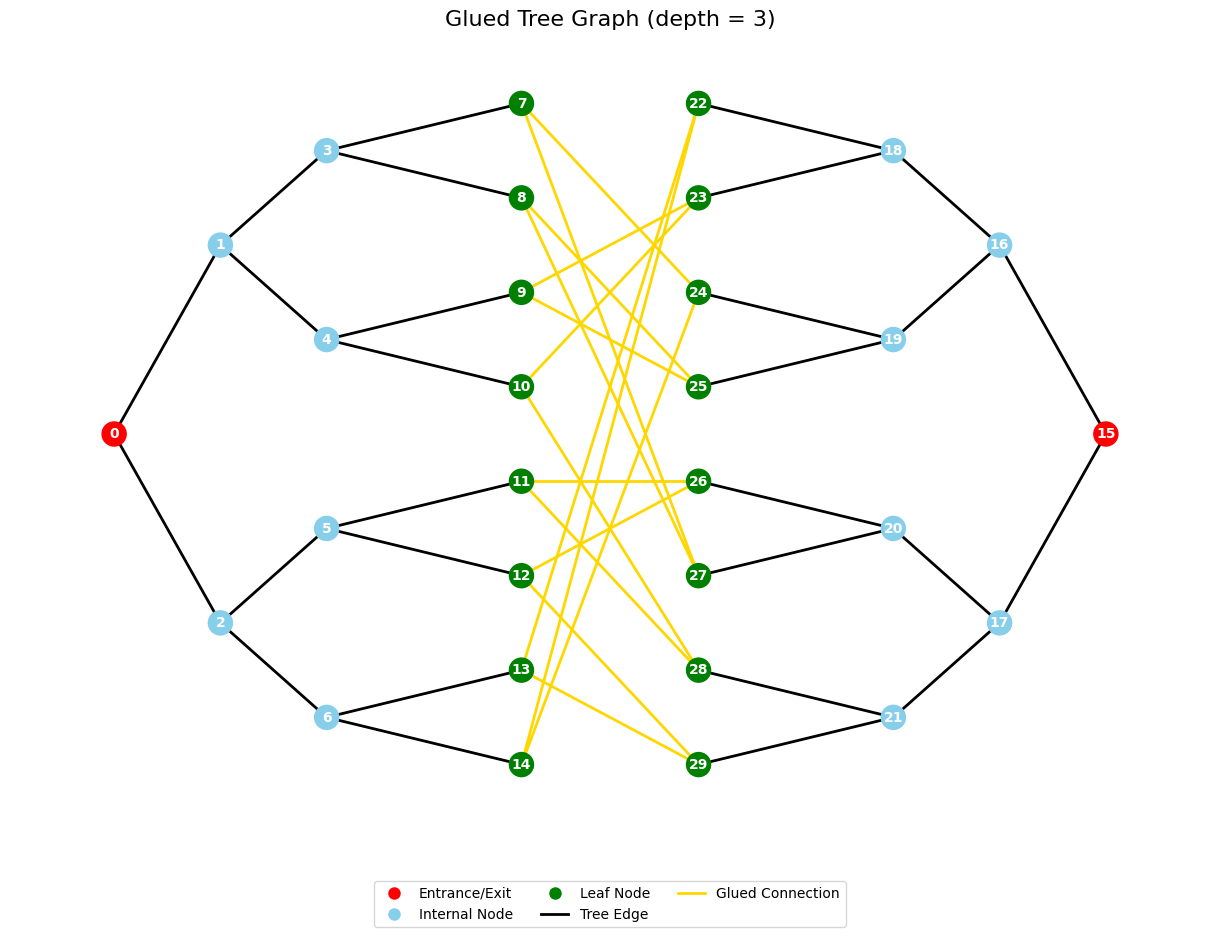

In [2]:
# Example usage
# Generate a Hamiltonian for a glued tree with depth 2
depth = 3
H = generate_glued_tree_hamiltonian(depth=depth)
# H = generate_glued_tree_hamiltonian(depth=depth, seed=42)

# Print the Hamiltonian
print_hamiltonian(H)

# Convert the Hamiltonian to a graph
G = hamiltonian_to_graph(H)

# Identify important components of the graph
components = identify_graph_components(H, depth)
print("\nGraph Components:")
print(f"  Entrance: {components['entrance']}")
print(f"  Exit: {components['exit']}")
print(f"  Tree 0 Leaves: {components['tree0_leaves']}")
print(f"  Tree 1 Leaves: {components['tree1_leaves']}")
print("  Glued Connections:")
for leaf0, leaf1 in components['glued_pairs']:
    print(f"    {leaf0} ↔ {leaf1}")

# Visualize the graph
visualize_glued_tree_graph(G, depth, save_file=f"./figs/childs_glued_tree_depth_{depth}.pdf")

In [3]:
from qiskit.quantum_info import Statevector
import numpy as np

dim = len(H)
# print(dim)
init_state = dim * [0]
init_state[0] = 1

t_list = np.linspace(0, 5, 100)
amp_entr = [expH(H, t).dot(init_state)[0] for t in t_list]
amp_exit = [expH(H, t).dot(init_state)[15] for t in t_list] # 15 is the exit node in the glued tree with depth 3
amp_midd = [expH(H, t).dot(init_state)[22] for t in t_list] # 22 is the middle node in the glued tree with depth 3

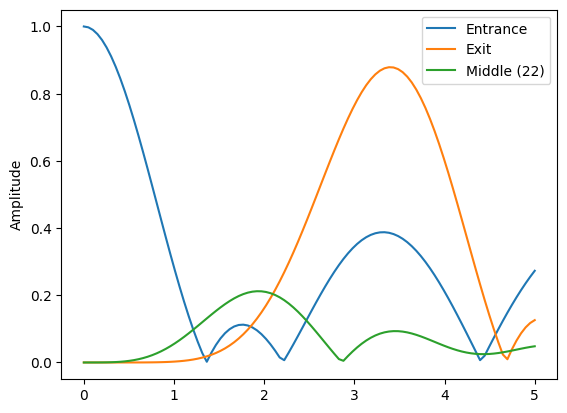

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(t_list, np.abs(amp_entr), label='Entrance')
axes.plot(t_list, np.abs(amp_exit), label='Exit')
axes.plot(t_list, np.abs(amp_midd), label='Middle (22)')
axes.set_ylabel('Amplitude')
axes.legend()

fig.savefig(f'./figs/childs_glued_tree_depth_{depth}_dqpt_middle.pdf')

## [todo] recover Childs Thesis figure.5-4 Prob V.S. columns at three different timesteps (check the propogation)

In [35]:
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy, schmidt_decomposition
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

In [58]:
def column_laplacian_H(n):
    N = 2*n + 1
    off = np.full(N-1, np.sqrt(2.0), dtype=float)
    off[n] = 2.0 
    A = diags([off, off], offsets=[-1,1], shape=(N,N), format="csr")
    degrees = np.zeros(N, dtype=float)
    degrees[:-1] += off
    degrees[1:]  += off
    D = diags([degrees], [0], shape=(N,N), format="csr")
    return (A - D).tocsr()

def evolve(H, n, t):
    N = 2*n + 1
    psi0 = np.zeros(N, dtype=complex)
    psi = Statevector(psi0)
    psi0[0] = 1.0
    psi_t = expm_multiply(-1j * H, psi0, start=0.0, stop=t, num=2)[-1]
    return np.abs(psi_t)**2

#     evolve_entropy(H, n, psi)
# def evolve_entropy(L, n, psi):
#     m = np.ceil(np.log2(n))
#     sub_dim = int(m // 2) 
#     t_list = np.linspace(0, 100, 100) 
    
#     subsystem = list(range(sub_dim))
#     entropy_list = [] 
#     for t in t_list: 
#         U = expm(-1j * L * t)
#         psi_t = Statevector(U @ psi.data)
#         dm = DensityMatrix(psi_t) 
#         rdm = partial_trace(dm, subsystem)
#         S = entropy(rdm)
#         entropy_list.append(S)

def plot_prob(probs, n, t):
    x = np.arange(0, 2*n+1)
    plt.plot(x, probs, linewidth=0.5)
    plt.xlabel("column")
    plt.ylabel("probability")
    plt.title(f" t={int(t)}")
    plt.xlim(0, 2*n)
    plt.show()


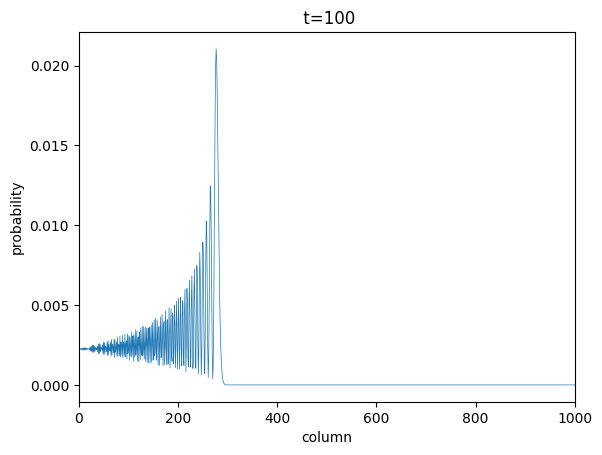

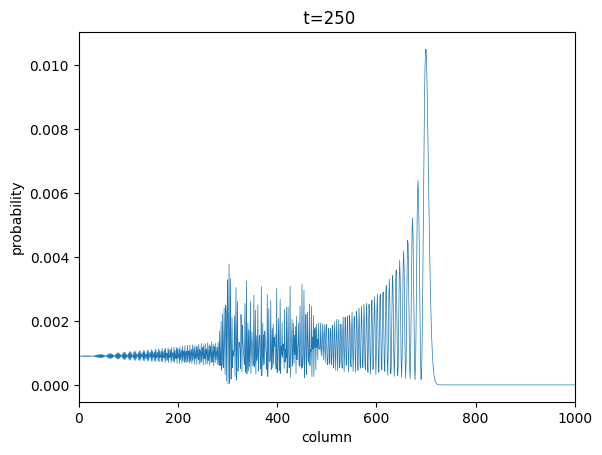

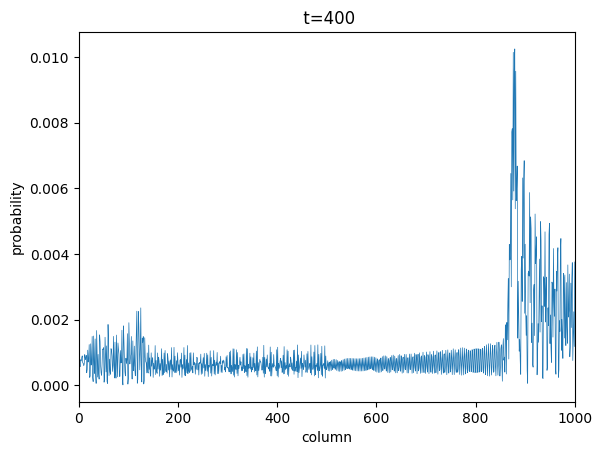

In [59]:
n = 500
times = [100, 250, 400]
H = column_laplacian_H(n)

for t in times:
    p = evolve(H, n, t)
    plot_prob(p, n, t)
